# MNIST

### Load Dataset

In [1]:
import urllib.request
import numpy as np

url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
filename = "mnist.npz"
urllib.request.urlretrieve(url, filename)

with np.load(filename) as data:
    x_train = data["x_train"].astype("float32") / 255.
    y_train = data["y_train"]
    x_test = data["x_test"].astype("float32") / 255.
    y_test = data["y_test"]

# Reshape (Flatten for Logistic Regression)
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

### Preprocessing

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from diffprivlib.models import LogisticRegression as DPLogisticRegression

# Set epsilons
epsilons = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]

accuracies_input = []
f1s_input = []
accuracies_internal = []
f1s_internal = []
accuracies_output = []
f1s_output = []

### 0. Baseline - Logistic Regression

#### 0-1. Logistic Regression

In [3]:
import time

start_time = time.time()

# Train
clf_base = LogisticRegression(max_iter=1000)
clf_base.fit(x_train_flat, y_train)

# Evaluation
y_pred = clf_base.predict(x_test_flat)
baseline_acc = accuracy_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred, average='weighted')

end_time = time.time()
baseline_runtime_lg = end_time - start_time

print("Baseline Accuracy:", baseline_acc)
print("Baseline F1 Score:", baseline_f1)
print(f"Baseline Runtime: {baseline_runtime_lg:.2f} seconds")

Baseline Accuracy: 0.9256
Baseline F1 Score: 0.9254454253831236
Baseline Runtime: 49.83 seconds


0-2. CNN

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

accuracies_cnn_input = []
f1s_cnn_input = []

# CNN Model
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

start_time = time.time()

model_baseline_cnn = build_simple_cnn()
model_baseline_cnn.fit(x_train[..., np.newaxis], y_train_cat,
                       epochs=5, batch_size=64, verbose=0)

cnn_baseline_acc, _ = model_baseline_cnn.evaluate(x_test[..., np.newaxis], y_test_cat, verbose=0)
y_pred_cnn_baseline = model_baseline_cnn.predict(x_test[..., np.newaxis])
y_pred_cnn_baseline_labels = np.argmax(y_pred_cnn_baseline, axis=1)
cnn_baseline_f1 = f1_score(y_test, y_pred_cnn_baseline_labels, average='weighted')

end_time = time.time()
baseline_runtime_cnn = end_time - start_time

print(f"Baseline CNN Accuracy: {cnn_baseline_acc:.4f}")
print(f"Baseline CNN F1 Score: {cnn_baseline_f1:.4f}")
print(f"Baseline CNN Runtime: {baseline_runtime_cnn:.2f} seconds")


2025-07-02 22:41:59.982869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-02 22:41:59.983104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-02 22:42:01.345562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:42:01.390205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:43:00.263187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU 

 97/313 [========>.....................] - ETA: 0s

2025-07-02 22:43:02.817211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 1ms/step
Baseline CNN Accuracy: 0.1482
Baseline CNN F1 Score: 0.9762
Baseline CNN Runtime: 63.44 seconds


### 1. Input Perturbation

#### Set Noise

In [3]:
def add_laplace_noise(data, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale, size=data.shape)
    return np.clip(data + noise, 0.0, 1.0)

#### 1-1. Logistic Regression

In [5]:
runtimes_input = []

for epsilon in epsilons:
    start_time = time.time()
    
    x_train_perturbed = add_laplace_noise(x_train_flat, epsilon)
    clf_input = LogisticRegression(max_iter=1000)
    clf_input.fit(x_train_perturbed, y_train)
    y_pred_input = clf_input.predict(x_test_flat)

    acc = accuracy_score(y_test, y_pred_input)
    f1 = f1_score(y_test, y_pred_input, average='weighted')
    
    accuracies_input.append(acc)
    f1s_input.append(f1)

    end_time = time.time()
    runtimes_input.append(end_time - start_time)

    print(f"Epsilon= {epsilon} : Acc: {acc:.4f}, F1: {f1:.4f}, Runtime: {end_time - start_time:.2f}s")


Epsilon =0.01 : Acc: 0.2159, F1: 0.1445, Runtime: 6.25s
Epsilon =0.1 : Acc: 0.5200, F1: 0.5208, Runtime: 9.86s
Epsilon =0.5 : Acc: 0.6812, F1: 0.6903, Runtime: 22.31s
Epsilon =1.0 : Acc: 0.7675, F1: 0.7675, Runtime: 48.59s
Epsilon =5.0 : Acc: 0.8744, F1: 0.8728, Runtime: 50.91s
Epsilon =10.0 : Acc: 0.8926, F1: 0.8917, Runtime: 47.19s


#### 1-2. CNN

In [10]:
runtimes_input_cnn = []

for epsilon in epsilons:    
    start_time = time.time()
    
    x_train_perturbed_cnn = add_laplace_noise(x_train, epsilon)
    model = build_simple_cnn()
    model.fit(x_train_perturbed_cnn[..., np.newaxis], y_train_cat,
              epochs=5, batch_size=64, verbose=0)
    
    test_loss, test_acc = model.evaluate(x_test[..., np.newaxis], y_test_cat, verbose=0)
    y_pred_cnn = model.predict(x_test[..., np.newaxis])
    y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)
    f1_cnn = f1_score(y_test, y_pred_cnn_labels, average='weighted')
    
    accuracies_cnn_input.append(test_acc)
    f1s_cnn_input.append(f1_cnn)

    end_time = time.time()
    runtimes_input_cnn.append(end_time - start_time)

    print(f"Epsilon= {epsilon} : Acc: {test_acc:.4f}, F1: {f1_cnn:.4f}, Runtime: {end_time - start_time:.2f}s")


2025-07-02 22:43:22.438506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:43:22.476351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:44:19.472931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 97/313 [========>.....................] - ETA: 0s

2025-07-02 22:44:21.825715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 0.01 : Acc: 0.1135, F1: 0.0231, Runtime: 61.70s


2025-07-02 22:44:24.049073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:44:24.087633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:45:19.036663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 97/313 [========>.....................] - ETA: 0s

2025-07-02 22:45:21.355298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 0.1 : Acc: 0.6316, F1: 0.5941, Runtime: 59.52s


2025-07-02 22:45:23.578734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:45:23.616789: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:46:18.653382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/313 [========>.....................] - ETA: 0s

2025-07-02 22:46:20.981031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 0.5 : Acc: 0.8712, F1: 0.8714, Runtime: 59.60s


2025-07-02 22:46:23.210698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:46:23.253744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:47:19.214982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 96/313 [========>.....................] - ETA: 0s

2025-07-02 22:47:21.533103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 1.0 : Acc: 0.9376, F1: 0.9370, Runtime: 60.76s


2025-07-02 22:47:23.914142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:47:23.953251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:48:19.204034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 94/313 [========>.....................] - ETA: 0s

2025-07-02 22:48:21.528205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 5.0 : Acc: 0.9766, F1: 0.9766, Runtime: 59.80s


2025-07-02 22:48:23.705449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-02 22:48:23.743068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-07-02 22:49:18.989781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 99/313 [========>.....................] - ETA: 0s

2025-07-02 22:49:21.288318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Epsilon= 10.0 : Acc: 0.9823, F1: 0.9823, Runtime: 59.76s


### 2. Internal Perturbation (IBM DiffPrivLib)

In [6]:
runtimes_internal = []

for epsilon in epsilons:
    start_time = time.time()

    clf_internal = DPLogisticRegression(epsilon=epsilon)
    clf_internal.fit(x_train_flat, y_train)
    y_pred_internal = clf_internal.predict(x_test_flat)

    acc = accuracy_score(y_test, y_pred_internal)
    f1 = f1_score(y_test, y_pred_internal, average='weighted')

    accuracies_internal.append(acc)
    f1s_internal.append(f1)

    end_time = time.time()
    runtimes_internal.append(end_time - start_time)

    print(f"Epsilon= {epsilon} : Acc: {acc:.4f}, F1: {f1:.4f}, Runtime: {end_time - start_time:.2f}s")

/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 0.01 : Acc: 0.1682, F1: 0.1261, Runtime: 2.24s


/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 0.1 : Acc: 0.1043, F1: 0.0702, Runtime: 2.53s


/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 0.5 : Acc: 0.1745, F1: 0.1531, Runtime: 3.05s


/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 1.0 : Acc: 0.1104, F1: 0.1126, Runtime: 2.91s


/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 5.0 : Acc: 0.4629, F1: 0.4578, Runtime: 4.44s


/opt/anaconda3/envs/dp_x86/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Epsilon= 10.0 : Acc: 0.5686, F1: 0.5670, Runtime: 6.57s


### 3. Output Perturbation (Noise to Weights)

In [7]:
def perturb_weights(model, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noisy_coef = model.coef_ + np.random.laplace(loc=0.0, scale=scale, size=model.coef_.shape)
    noisy_intercept = model.intercept_ + np.random.laplace(loc=0.0, scale=scale, size=model.intercept_.shape)
    model.coef_ = noisy_coef
    model.intercept_ = noisy_intercept
    return model

runtimes_output = []

for epsilon in epsilons:
    start_time = time.time()

    clf_output = LogisticRegression(max_iter=1000)
    clf_output.fit(x_train_flat, y_train)
    clf_output = perturb_weights(clf_output, epsilon)
    y_pred_output = clf_output.predict(x_test_flat)

    acc = accuracy_score(y_test, y_pred_output)
    f1 = f1_score(y_test, y_pred_output, average='weighted')

    accuracies_output.append(acc)
    f1s_output.append(f1)

    end_time = time.time()
    runtimes_output.append(end_time - start_time)

    print(f"Epsilon= {epsilon} : Acc: {acc:.4f}, F1: {f1:.4f}, Runtime: {end_time - start_time:.2f}s")

Epsilon= 0.01 : Acc: 0.0675, F1: 0.0435, Runtime: 49.27s
Epsilon= 0.1 : Acc: 0.1619, F1: 0.1273, Runtime: 49.08s
Epsilon= 0.5 : Acc: 0.1966, F1: 0.1806, Runtime: 49.09s
Epsilon= 1.0 : Acc: 0.3018, F1: 0.2534, Runtime: 49.91s
Epsilon= 5.0 : Acc: 0.8177, F1: 0.8181, Runtime: 49.24s
Epsilon= 10.0 : Acc: 0.8861, F1: 0.8876, Runtime: 49.34s


### Results

#### Accuracy and F1-score

In [12]:
import pandas as pd

results_df = pd.DataFrame({
    "Epsilon": epsilons,
    "Input LogReg Acc": accuracies_input,
    "Input LogReg F1": f1s_input,
    "Input CNN Acc": accuracies_cnn_input,
    "Input CNN F1": f1s_cnn_input,
    "Internal LogReg Acc": accuracies_internal,
    "Internal LogReg F1": f1s_internal,
    "Output LogReg Acc": accuracies_output,
    "Output LogReg F1": f1s_output
})

display(results_df.round(4))

,Epsilon,Input LogReg Acc,Input LogReg F1,Input CNN Acc,Input CNN F1,Internal LogReg Acc,Internal LogReg F1,Output LogReg Acc,Output LogReg F1
0,0.01,0.2159,0.1445,0.1135,0.0231,0.1682,0.1261,0.0675,0.0435
1,0.10,0.5200,0.5208,0.6316,0.5941,0.1043,0.0702,0.1619,0.1273
2,0.50,0.6812,0.6903,0.8712,0.8714,0.1745,0.1531,0.1966,0.1806
3,1.00,0.7675,0.7675,0.9376,0.9370,0.1104,0.1126,0.3018,0.2534
4,5.00,0.8744,0.8728,0.9766,0.9766,0.4629,0.4578,0.8177,0.8181
5,10.00,0.8926,0.8917,0.9823,0.9823,0.5686,0.5670,0.8861,0.8876


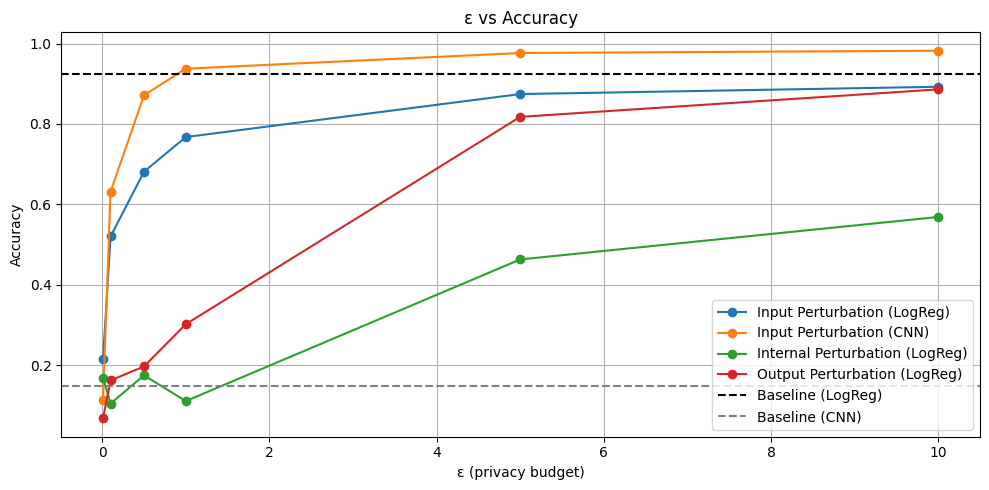

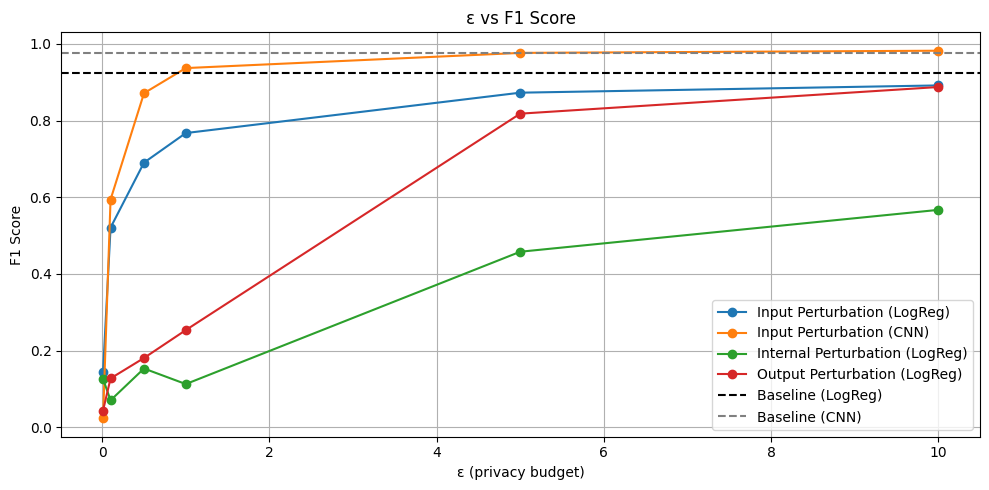

In [15]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies_input, marker='o', label='Input Perturbation (LogReg)')
plt.plot(epsilons, accuracies_cnn_input, marker='o', label='Input Perturbation (CNN)')
plt.plot(epsilons, accuracies_internal, marker='o', label='Internal Perturbation (LogReg)')
plt.plot(epsilons, accuracies_output, marker='o', label='Output Perturbation (LogReg)')
plt.axhline(y=baseline_acc, color='black', linestyle='--', label='Baseline (LogReg)')
plt.axhline(y=cnn_baseline_acc, color='gray', linestyle='--', label='Baseline (CNN)')
plt.title("ε vs Accuracy")
plt.xlabel("ε (privacy budget)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# F1 Score Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, f1s_input, marker='o', label='Input Perturbation (LogReg)')
plt.plot(epsilons, f1s_cnn_input, marker='o', label='Input Perturbation (CNN)')
plt.plot(epsilons, f1s_internal, marker='o', label='Internal Perturbation (LogReg)')
plt.plot(epsilons, f1s_output, marker='o', label='Output Perturbation (LogReg)')
plt.axhline(y=baseline_f1, color='black', linestyle='--', label='Baseline (LogReg)')
plt.axhline(y=cnn_baseline_f1, color='gray', linestyle='--', label='Baseline (CNN)')
plt.title("ε vs F1 Score")
plt.xlabel("ε (privacy budget)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Privacy Utility Trade-off

In [16]:
performance_drop_input_logreg_acc = [baseline_acc - acc for acc in accuracies_input]
performance_drop_input_logreg_f1 = [baseline_f1 - f1 for f1 in f1s_input]

performance_drop_input_cnn_acc = [cnn_baseline_acc - acc for acc in accuracies_cnn_input]
performance_drop_input_cnn_f1 = [cnn_baseline_f1 - f1 for f1 in f1s_cnn_input]

performance_drop_internal_acc = [baseline_acc - acc for acc in accuracies_internal]
performance_drop_internal_f1 = [baseline_f1 - f1 for f1 in f1s_internal]

performance_drop_output_acc = [baseline_acc - acc for acc in accuracies_output]
performance_drop_output_f1 = [baseline_f1 - f1 for f1 in f1s_output]

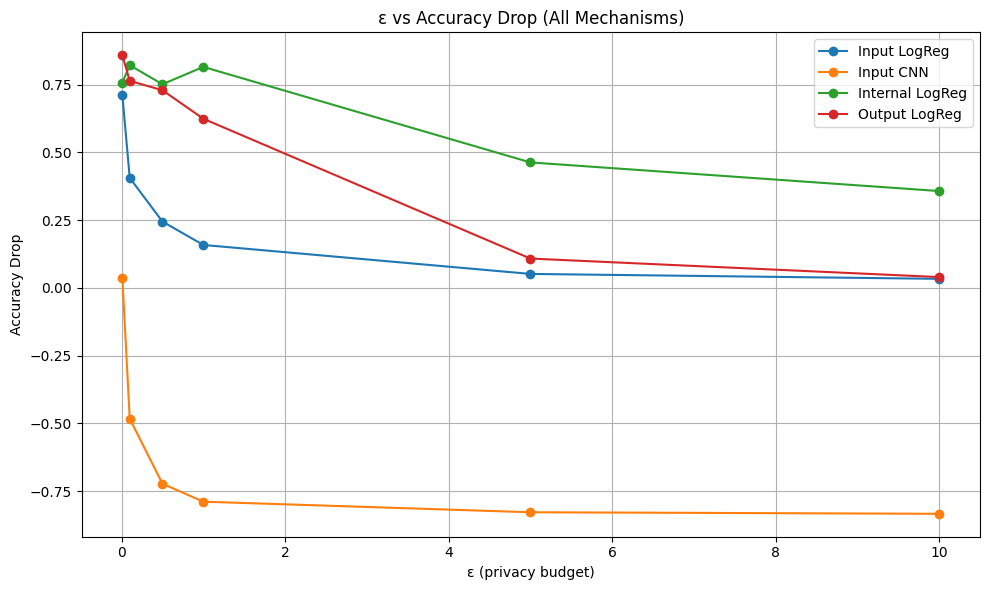

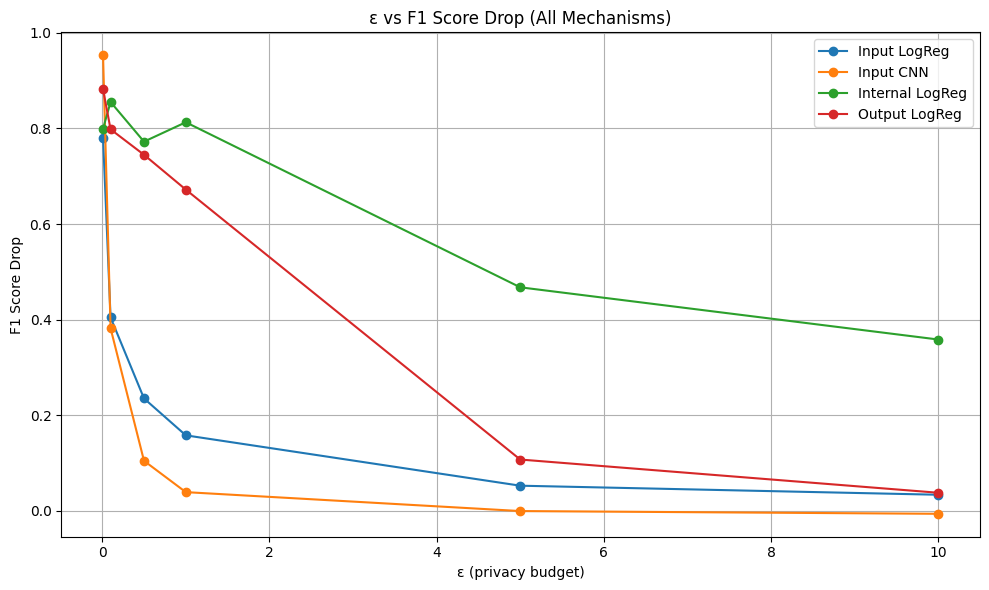

In [17]:
# Accuracy 
plt.figure(figsize=(10, 6))
plt.plot(epsilons, performance_drop_input_logreg_acc, marker='o', label='Input LogReg')
plt.plot(epsilons, performance_drop_input_cnn_acc, marker='o', label='Input CNN')
plt.plot(epsilons, performance_drop_internal_acc, marker='o', label='Internal LogReg')
plt.plot(epsilons, performance_drop_output_acc, marker='o', label='Output LogReg')
plt.title("ε vs Accuracy Drop (All Mechanisms)")
plt.xlabel("ε (privacy budget)")
plt.ylabel("Accuracy Drop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epsilons, performance_drop_input_logreg_f1, marker='o', label='Input LogReg')
plt.plot(epsilons, performance_drop_input_cnn_f1, marker='o', label='Input CNN')
plt.plot(epsilons, performance_drop_internal_f1, marker='o', label='Internal LogReg')
plt.plot(epsilons, performance_drop_output_f1, marker='o', label='Output LogReg')
plt.title("ε vs F1 Score Drop (All Mechanisms)")
plt.xlabel("ε (privacy budget)")
plt.ylabel("F1 Score Drop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Runtime and scalability

In [ ]:
runtime_table = pd.DataFrame({
    "Epsilon": epsilons,
    "Runtime_Input_LogReg": runtimes_input,
    "Runtime_Input_CNN": runtimes_input_cnn,
    "Runtime_Internal_LogReg": runtimes_internal,
    "Runtime_Output_LogReg": runtimes_output
})

# Baseline runtime
baseline_runtime_row = pd.DataFrame({
    "Epsilon": ["Baseline"],
    "Runtime_Input_LogReg": [baseline_runtime_lg],
    "Runtime_Input_CNN": [baseline_runtime_cnn],
    "Runtime_Internal_LogReg": [None],
    "Runtime_Output_LogReg": [None]
})


runtime_summary = pd.concat([baseline_runtime_row, runtime_table], ignore_index=True)
display(runtime_summary)


/var/folders/cy/l2ktp03s39lbmfwlpmf4p21m0000gn/T/ipykernel_89463/320967661.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runtime_summary = pd.concat([baseline_runtime_row, runtime_table], ignore_index=True)


,Epsilon,Runtime_Input_LogReg,Runtime_Input_CNN,Runtime_Internal_LogReg,Runtime_Output_LogReg
0,Baseline,49.832517,63.435105,NaN,NaN
1,0.01,6.252004,61.700307,2.236480,49.271714
2,0.1,9.861874,59.517670,2.532274,49.081348
3,0.5,22.313054,59.600688,3.049486,49.088706
4,1.0,48.585683,60.761438,2.907175,49.905017
5,5.0,50.909346,59.797966,4.444886,49.242511
6,10.0,47.194315,59.758977,6.574533,49.335177


#### Visual analysis

In [5]:
def visualize_noisy_images(x_clean, epsilons, num_samples=5):
    plt.figure(figsize=(len(epsilons)*2, num_samples*2))
    for col, eps in enumerate(epsilons):
        x_noisy = add_laplace_noise(x_clean[:num_samples], epsilon=eps)
        for row in range(num_samples):
            plt.subplot(num_samples, len(epsilons), row*len(epsilons) + col + 1)
            plt.imshow(x_noisy[row], cmap='gray')
            if row == 0:
                plt.title(f"ε={eps}")
            plt.axis('off')
    plt.suptitle("Input Perturbation Visual Effect by ε")
    plt.tight_layout()
    plt.show()

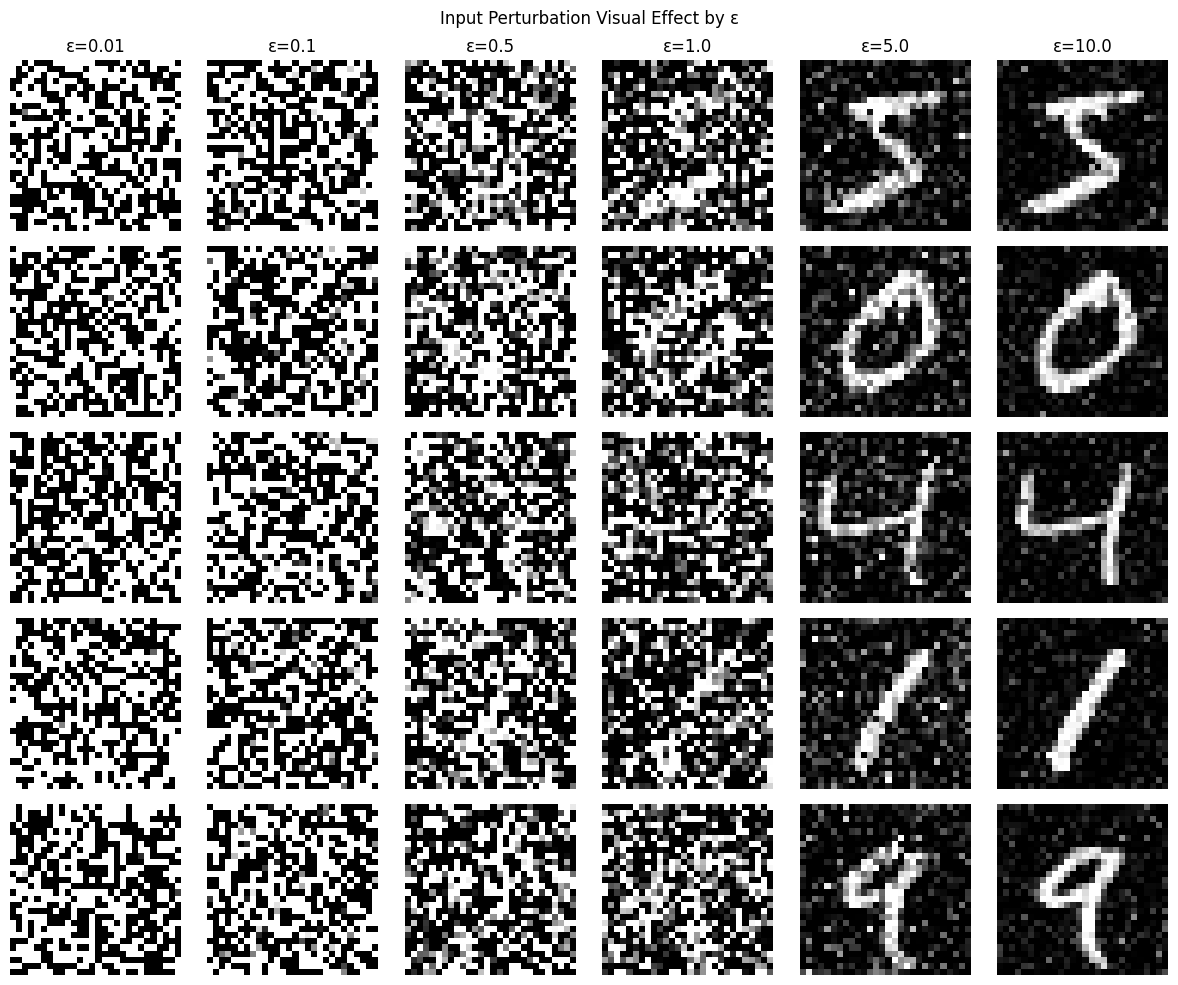

In [ ]:
visualize_noisy_images(x_train, [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], num_samples=5)